In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np
from arch.unitroot import PhillipsPerron
from dotenv import load_dotenv
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VAR
from math import log



load_dotenv()
path_to_data = os.getenv("PATH_TO_DATA") 

def get_data(ticker1, ticker2, path_to_data):
    pair_paths = dict()
    for root, dirs, files in os.walk(path_to_data):
        for name in files:
            if name == f"{ticker1}.csv":
                ticker1_path = str(os.path.join(root, name))
                pair_paths[ticker1] = ticker1_path
            elif name == f"{ticker2}.csv":
                ticker2_path = str(os.path.join(root, name))
                pair_paths[ticker2] = ticker2_path
    return pair_paths

ticker1 = "AZN"
ticker2 = "PFE"

start_time = "2004-06-16"
end_time = "2016-06-16"

pair_paths = get_data(ticker1, ticker2, path_to_data)


with open(rf"{pair_paths[ticker1]}", "r") as s1:
    with open(rf"{pair_paths[ticker2]}", "r") as s2:
        price_df1 = pd.read_csv(s1)
        print(ticker1 + "\n", price_df1)

        price_df2 = pd.read_csv(s2)
        print(ticker2 + "\n", price_df2)

AZN
       Unnamed: 0    datetime   open   high    low  close   volume
0              0  2023-04-19  74.55  74.90  74.41  74.84  4487800
1              1  2023-04-18  75.36  75.83  74.47  75.02  7565700
2              2  2023-04-17  73.76  73.82  73.01  73.63  4408700
3              3  2023-04-14  74.33  74.47  73.57  73.86  3981100
4              4  2023-04-13  74.05  74.83  74.02  74.77  3794200
...          ...         ...    ...    ...    ...    ...      ...
4740        4740  2004-06-21  23.75  23.80  23.63  23.63   841400
4741        4741  2004-06-18  23.79  23.94  23.77  23.77  1615200
4742        4742  2004-06-17  23.64  23.70  23.52  23.68  1135600
4743        4743  2004-06-16  23.75  23.82  23.63  23.77  1060400
4744        4744  2004-06-15  23.43  23.57  23.39  23.48  1637400

[4745 rows x 7 columns]
PFE
       Unnamed: 0    datetime   open   high    low  close    volume
0              0  2023-04-19  40.43  40.56  40.20  40.24  17207800
1              1  2023-04-18  41.28  41

In [82]:
def clean_df(price_df, start_time, end_time):
    price_df = price_df.set_index('datetime')
    price_df.index = pd.to_datetime(price_df.index)
    
    new_price_df = price_df['close'].copy()
    new_price_df = new_price_df.truncate(start_time, end_time)
    
    return new_price_df

price_df1 = clean_df(price_df1, start_time, end_time)
price_df2 = clean_df(price_df2, start_time, end_time)
print(ticker1 + "\n", price_df1)
print(ticker2 + "\n", price_df2)



AZN
 datetime
2016-06-16    27.63
2016-06-15    27.37
2016-06-14    27.26
2016-06-13    27.60
2016-06-10    27.97
              ...  
2004-06-22    23.55
2004-06-21    23.63
2004-06-18    23.77
2004-06-17    23.68
2004-06-16    23.77
Name: close, Length: 3023, dtype: float64
PFE
 datetime
2016-06-16    32.94
2016-06-15    32.98
2016-06-14    33.17
2016-06-13    32.93
2016-06-10    33.45
              ...  
2004-06-22    33.08
2004-06-21    33.37
2004-06-18    33.59
2004-06-17    33.43
2004-06-16    33.39
Name: close, Length: 3023, dtype: float64


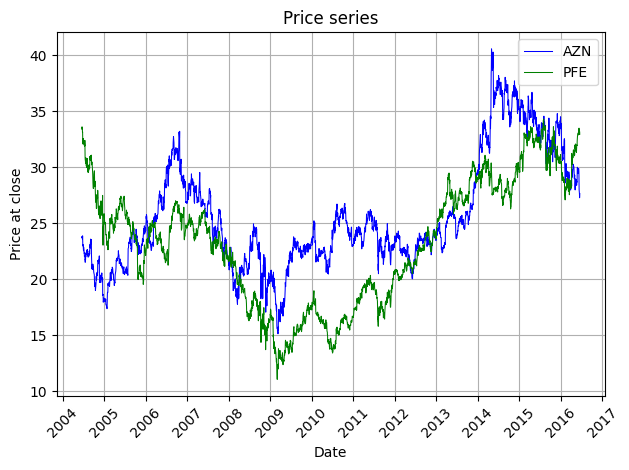

In [83]:
def plot_df(price_df1, price_df2=None, merge_and_plot=False, title="", xlabel="", ylabel="", color="blue"):
    plt.style.use('default')
    
    if merge_and_plot and price_df2 is not None:
        plt.plot(price_df1, color="blue", linewidth=0.75, label=ticker1)
        plt.plot(price_df2, color="green", linewidth=0.75, label=ticker2)
        plt.legend()
    else:
        plt.plot(price_df1, color, linewidth=0.75)
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    year_locator = mdates.YearLocator(base=1)
    plt.gca().xaxis.set_major_locator(year_locator)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_df(price_df1, price_df2, merge_and_plot=True, title="Price series", xlabel="Date", ylabel="Price at close")


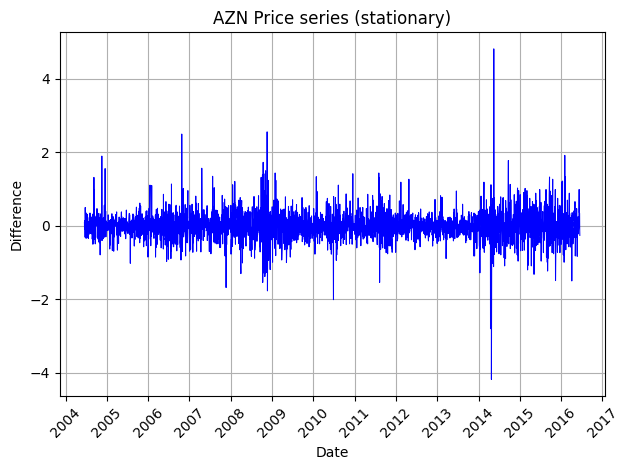

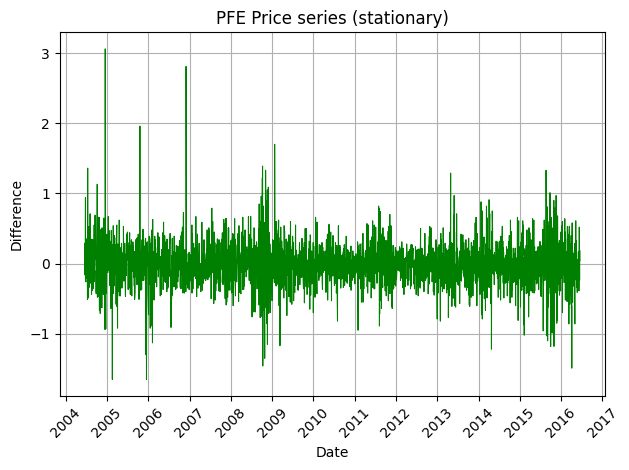

In [84]:
def difference(price_series):
    new_series = price_series - price_series.shift(1)
    new_series = new_series.dropna() 
    new_series.index = price_series.index[1:]
    return new_series

price_df1 = difference(price_df1)
price_df2 = difference(price_df2)

plot_df(price_df1, title=f"{ticker1} Price series (stationary)", xlabel="Date", ylabel="Difference", color="blue")
plot_df(price_df2, title=f"{ticker2} Price series (stationary)", xlabel="Date", ylabel="Difference", color="green")

In [85]:
pp1 = PhillipsPerron(price_df1, trend='n')
print(ticker1 + "...\n", str(pp1.summary()), "\n")

pp2 = PhillipsPerron(price_df2, trend='n')
print(ticker2 + "...\n", str(pp2.summary()))

AZN...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -56.821
P-value                         0.000
Lags                               29
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

PFE...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -55.436
P-value                         0.000
Lags                               29
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [86]:
def bayesian_info_crit(price_df, lag_order=range(1,10)):
    price_df = price_df.apply(pd.to_numeric, errors='coerce')
    price_df_copy = pd.DataFrame()
    price_df_copy['Datetime'] = price_df.index
    price_df_copy['Price'] = price_df.values
    bic_values= []
    var_models = []
    print(price_df_copy)
    for lag in lag_order:
        model = VAR(price_df_copy)
        results = model.fit(lag)
        var_models.append(results)
        
        n = len(price_df_copy)
        sse = results.sse
        k = results.df_model
        bic = n * log(sse/n) + k * log(n)
        bic_values.append(bic)
    return bic_values

print(bayesian_info_crit(price_df1, lag_order=range(1,10)))





       Datetime  Price
0    2016-06-15  -0.26
1    2016-06-14  -0.11
2    2016-06-13   0.34
3    2016-06-10   0.37
4    2016-06-09   0.99
...         ...    ...
3017 2004-06-22  -0.31
3018 2004-06-21   0.08
3019 2004-06-18   0.14
3020 2004-06-17  -0.09
3021 2004-06-16   0.09

[3022 rows x 2 columns]


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).